## Test Group Equivariant canonicalization
In this notebook, we test the whether the group equivariant image canonicalizers can generate a canonical orientation properly for sample images. We also visualize the original and canonicalized images to see if the canonicalization is successful.

In [15]:
import torch
from torchvision import datasets, transforms
from equiadapt.images.canonicalization.discrete_group import GroupEquivariantImageCanonicalization, OptimizedGroupEquivariantImageCanonicalization
from equiadapt.images.canonicalization_networks import ESCNNEquivariantNetwork, ConvNetwork
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np
from tqdm import tqdm

### 1. Load the CIFAR-10 dataset
First load the dataset and the dataloader.

In [16]:
# Load the CIFAR10 dataset
transform = transforms.Compose([transforms.ToTensor()])

data_path = '/home/mila/a/arnab.mondal/scratch/equiadapt/image/data/cifar10'
cifar10 = datasets.CIFAR10(root=data_path, train=True, download=False, transform=transform)
data_loader = torch.utils.data.DataLoader(cifar10, batch_size=512, shuffle=True)

Visulize the original images.

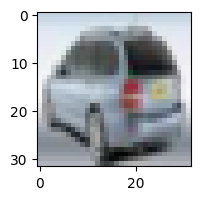

In [19]:
sample_data = next(iter(data_loader))
# Visualize the original image
sample_image = sample_data[0][0].permute(1, 2, 0).numpy()

plt.figure(figsize=(2, 2))
plt.imshow(sample_image)
plt.show()

### 2. Check for canonicalization for steerable image canonicalizers



We first test it for SO(2) which is a 2D rotation group.
For this we first transform the image to k random rotations and then apply the steerable canonicalization to the image. 
We then check if the canonicalized image is the same as the original image.

In [20]:
# Transform the image using k random rotations
# number of random rotations
k = 4
# Original tensor image from the DataLoader
sample_image_tensor = sample_data[0][0]  # Assuming the first item is your image tensor

# Define an empty list to store the transformed tensor images
transformed_sample_images = []

# Get the shape of the image tensor
h, w = sample_image_tensor.shape[-2:]

# Pad the image to get rid of the black borders
pad = transforms.Pad(10, padding_mode='edge')

# crop the image to get rid of the black borders
crop = transforms.CenterCrop((h, w))
# Loop over the number of random rotations
# and transform the image tensor using torch rotation
for i in range(k):
    # Generate a random angle for rotation
    angle = 90 * i
    
    # Pad the image to get rid of the black borders
    padded_image_tensor = pad(sample_image_tensor)
    
    # Apply the rotation to the tensor
    transformed_image_tensor = F.rotate(padded_image_tensor, angle)
    
    # Add the transformed tensor to the list
    transformed_sample_images.append(crop(transformed_image_tensor))



Function to visualize a list of image tensors.

In [21]:
def plot_image_tensors(image_tensors, titles=None, figsize=(4, 4)):
    """
    Plots a list of image tensors in a grid.

    Parameters:
    - image_tensors: List[Tensor]. A list of image tensors in (C, H, W) format.
    - titles: List[str]. Optional. A list of titles for each subplot.
    - figsize: tuple. The figure size.
    """
    # Determine the number of images
    num_images = len(image_tensors)

    # Calculate grid size for the subplots
    rows = int(torch.sqrt(torch.tensor(num_images)).item())
    cols = (num_images + rows - 1) // rows  # Ensure enough columns to display all images

    # Create a figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # Flatten axes array for easy iteration, in case of a single row/column
    axes = axes.flatten()

    # Loop through all the images and their corresponding axes
    for i, (img_tensor, ax) in enumerate(zip(image_tensors, axes)):
        # Convert the tensor for visualization
        img_np = img_tensor.squeeze().permute(1, 2, 0).numpy()
        
        # Plot the image
        ax.imshow(img_np)
        ax.axis('off')  # Hide the axis

        # Set title if titles are provided
        if titles and i < len(titles):
            ax.set_title(titles[i])

    # If there are more axes than images, hide the extra axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()

Visualize the transformed images

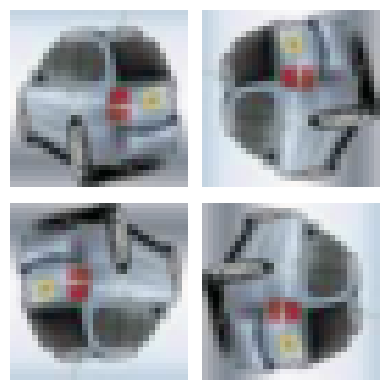

In [22]:
# Visualizing all the transformed images 
plot_image_tensors(transformed_sample_images)

Define a steerable canonicalization network and a SteerableImageCanonicalization object.

In [30]:
# Get the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the hyperparameters for the canonicalization network
class CanonicalizationHyperparams:
    def __init__(self):
        self.input_crop_ratio = 0.5
        self.beta = 1.0 # Beta parameter for the canonization network
        self.resize_shape = 32 # The shape of the image after resizing

# Create an instance of the hyperparameters
canonicalization_hyperparams = CanonicalizationHyperparams()

# Get the shape of the image
image_shape = sample_image_tensor.squeeze().shape

# Print the image shape
print(f"Image shape: {image_shape}")

# Define a steerable canonicalization network
# Note that you define any steerable network here as long as it outputs 
# a vector that steers with the input image
# This vector is used to get a rotation matrix in a differentiable manner 
canonicalization_network = ESCNNEquivariantNetwork(
    in_shape = image_shape,
    out_channels=16, 
    kernel_size= 9, 
    num_layers = 3,
    group_type='rotation', 
    num_rotations=4, 
).to(device)


# Create a steerable canonicalization object
canonicalizer = GroupEquivariantImageCanonicalization(
    canonicalization_network=canonicalization_network,
    canonicalization_hyperparams=canonicalization_hyperparams,
    in_shape=image_shape,
)

Image shape: torch.Size([3, 32, 32])


Canonicalize all the transformed images and visualize the canonicalized images.

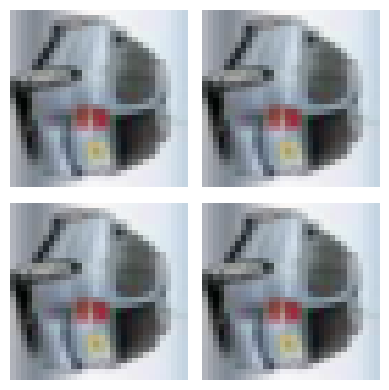

In [25]:
# Get canonicalized images for all transformed images
canonicalized_images = []
for im in transformed_sample_images:
    im = im.unsqueeze(0).to(device)
    canonicalized_image = canonicalizer.canonicalize(im)
    canonicalized_images.append(canonicalized_image.detach().cpu())

# Visualizing all the canonicalized images
plot_image_tensors(canonicalized_images)
    

In [31]:
# Train the canonicalization network using prior regularization

# Define the optimizer
optimizer = torch.optim.Adam(canonicalization_network.parameters(), lr=0.005)

# Define the training loop
num_epochs = 50
for epoch in range(num_epochs):
    # Use tqdm to visualize the progress
    # and loop over the data loader
    identity_metric = 0
    for image, _ in tqdm(data_loader):
        # Zero the gradients
        optimizer.zero_grad()
        
        image = image.to(device)
        canonicalized_image = canonicalizer.canonicalize(image)
        
        # Get the prior regularization loss
        prior_loss = canonicalizer.get_prior_regularization_loss()
        
        # Combine the losses
        loss = prior_loss * 100
        
        # Backpropagate the gradients
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        # Update the running average of identity metric
        identity_metric += canonicalizer.get_identity_metric()
    
    # Get the average identity metric
    identity_metric /= len(data_loader)
    
    # Print the identity metric
    print(f"Epoch {epoch+1}/{num_epochs}, : Identity metric = {identity_metric:.4f}")
        
        
    

  0%|          | 0/98 [00:00<?, ?it/s]

100%|██████████| 98/98 [00:06<00:00, 16.24it/s]


Epoch 1/50, : Identity metric = 0.4342


100%|██████████| 98/98 [00:06<00:00, 16.05it/s]


Epoch 2/50, : Identity metric = 0.4844


100%|██████████| 98/98 [00:06<00:00, 16.28it/s]


Epoch 3/50, : Identity metric = 0.5060


100%|██████████| 98/98 [00:05<00:00, 16.34it/s]


Epoch 4/50, : Identity metric = 0.5254


100%|██████████| 98/98 [00:05<00:00, 16.35it/s]


Epoch 5/50, : Identity metric = 0.5342


100%|██████████| 98/98 [00:06<00:00, 16.33it/s]


Epoch 6/50, : Identity metric = 0.5476


100%|██████████| 98/98 [00:06<00:00, 16.07it/s]


Epoch 7/50, : Identity metric = 0.5546


100%|██████████| 98/98 [00:06<00:00, 16.33it/s]


Epoch 8/50, : Identity metric = 0.5629


100%|██████████| 98/98 [00:06<00:00, 16.33it/s]


Epoch 9/50, : Identity metric = 0.5672


100%|██████████| 98/98 [00:06<00:00, 16.33it/s]


Epoch 10/50, : Identity metric = 0.5718


100%|██████████| 98/98 [00:06<00:00, 16.33it/s]


Epoch 11/50, : Identity metric = 0.5746


100%|██████████| 98/98 [00:06<00:00, 15.89it/s]


Epoch 12/50, : Identity metric = 0.5805


100%|██████████| 98/98 [00:06<00:00, 16.05it/s]


Epoch 13/50, : Identity metric = 0.5854


100%|██████████| 98/98 [00:06<00:00, 16.30it/s]


Epoch 14/50, : Identity metric = 0.5858


100%|██████████| 98/98 [00:06<00:00, 16.27it/s]


Epoch 15/50, : Identity metric = 0.5871


100%|██████████| 98/98 [00:06<00:00, 16.30it/s]


Epoch 16/50, : Identity metric = 0.5930


100%|██████████| 98/98 [00:06<00:00, 16.28it/s]


Epoch 17/50, : Identity metric = 0.5925


100%|██████████| 98/98 [00:06<00:00, 16.04it/s]


Epoch 18/50, : Identity metric = 0.5965


100%|██████████| 98/98 [00:06<00:00, 16.22it/s]


Epoch 19/50, : Identity metric = 0.5987


100%|██████████| 98/98 [00:06<00:00, 16.20it/s]


Epoch 20/50, : Identity metric = 0.5980


 47%|████▋     | 46/98 [00:02<00:03, 16.24it/s]